This is a notebook to explore transport calculations.

Plan
* interolate currents to transect
* find perpendicular component of currents at each point on transect
* sum over all transects pieces

In [1]:
import os
import glob

from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline

# Data loading

In [2]:
data_dir='/ocean/handres/glorys12/'
mask = xr.open_dataset(os.path.join(data_dir,'statics_subset_mask_bathy.nc'))
coords = xr.open_dataset(os.path.join(data_dir,'statics_subset_coordinates.nc'))

In [3]:
year='2003'
month='01'
f = glob.glob(os.path.join(data_dir,f'*{year}_daily{month}.nc'))
d = xr.open_mfdataset(f)

In [4]:
transects = pd.read_csv('../../data/sections_info.txt', delim_whitespace=True,
                       names=['Shortname', 'Longname', 'lon1', 'lat1', 'lon2', 'lat2', 'Dir-E', 'Dir-N'],
                       header=0)

In [5]:
transects

,Shortname,Longname,lon1,lat1,lon2,lat2,Dir-E,Dir-N
0,Ac,Anticosti,-64.800000,49.000000,-64.420000,49.900000,1,-1
1,BB_AZMP,BB-AZMP,-65.515182,43.542454,-65.414833,41.822609,-1,1
2,Bv,Bonavista,-53.070000,48.630000,-49.000000,50.000000,1,-1
3,BB,Bonne-Bay,-59.930000,50.590000,-57.990000,49.330000,-1,-1
4,CSI,CSI,-65.585000,43.469000,-66.008000,42.544000,-1,1
5,CS,Cabot-Strait,-60.620000,46.960000,-59.000000,47.800000,1,-1
6,Es,Estuary,-68.490000,48.300000,-68.750000,49.100000,1,1
7,FC,Flemish-Cap,-52.930000,47.000000,-43.000000,47.000000,-1,-1
8,Hfx,Halifax,-63.460000,44.700000,-61.400000,42.530000,-1,-1
9,Lb,Louisbourg,-59.850000,46.030000,-57.530000,43.470000,-1,-1


# Supporting functions

## integration and interpolation

In [6]:
def depth_integrate(var, mask, e3t, depth_axis=0):
    """Return depth integrated variable
    """
    return np.sum(var*mask*e3t, axis=depth_axis)

In [7]:
ubar = depth_integrate(d.uo, mask.mask, coords.e3t, depth_axis=1)

In [8]:
vbar = depth_integrate(d.vo, mask.mask, coords.e3t, depth_axis=1)

In [9]:
def interpolate_transect(var, lons, lats,method='linear'):
    lons = xr.DataArray(lons, dims='transect')
    lats = xr.DataArray(lats, dims='transect')
    return var.interp(longitude=lons,latitude=lats,method=method)

In [10]:
lon1=transects[transects.Shortname=='SBI'].lon1.values[0]
lon2=transects[transects.Shortname=='SBI'].lon2.values[0]
lat1=transects[transects.Shortname=='SBI'].lat1.values[0]
lat2=transects[transects.Shortname=='SBI'].lat2.values[0]

In [11]:
num=100
lons = np.linspace(lon1, lon2)
lats = np.linspace(lat1, lat2)
ubar_interp = interpolate_transect(ubar,lons, lats)
vbar_interp = interpolate_transect(vbar,lons, lats)

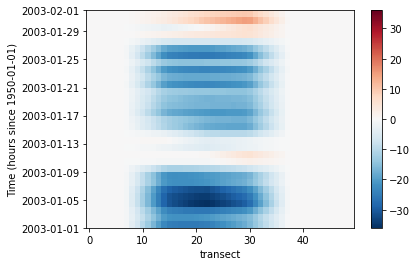

In [12]:
ubar_interp.plot()

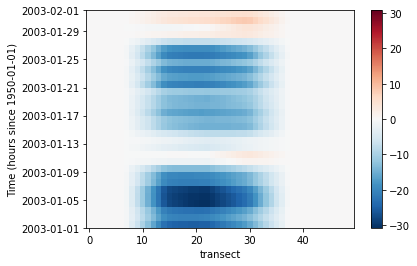

In [13]:
vbar_interp.plot()

## projections

In [14]:
def dot(a,b):
    """dot product between vectors a, b where a and b are complex"""
    return np.real(a)*np.real(b) + np.imag(a)*np.imag(b)

In [15]:
def proj_vector(vector, ref_vector):
    """project vector onto ref_vector, where vector and ref_vector are complex numbers"""
    return (dot(vector, ref_vector)/dot(ref_vector, ref_vector)*ref_vector)

In [16]:
def proj_vector_perp(vector, ref_vector):
    """project vector onto the vector rotated 90 deg CCW from ref_vector"""
    return proj_vector(vector, 1j*ref_vector)

In [17]:
def change_axis(vector, ref_vector):
    """Rotate vector to along and across components of ref_vector"""
    along = np.sign(dot(vector, ref_vector))*np.abs(proj_vector(vector, ref_vector))
    across = np.sign(dot(vector, 1j*ref_vector))*np.abs(proj_vector_perp(vector, ref_vector))
    return along + 1j*across

## transects and distances

In [18]:
def vectorize_transect(lons, lats, dir_east_perp, dir_north_perp):
    across_vector = dir_east_perp + 1j*dir_north_perp
    along_vector  = -1j*across_vector # rotate 90 CW to get along vector
    dir_east_along = np.real(along_vector)
    dir_north_along = np.imag(along_vector)
    n = len(lons) - 1
    vector = np.empty((n,),dtype=complex)
    for i in range(n):
        x = distance((lons[i], lats[i]), (lons[i+1], lats[i])).m
        y = distance((lons[i], lats[i]), (lons[i], lats[i+1])).m
        vector[i] = dir_east_along*x + dir_north_along*1j*y
    return vector

In [19]:
dir_east_perp = transects[transects.Shortname=='SBI']['Dir-E'].values[0]
dir_north_perp = transects[transects.Shortname=='SBI']['Dir-N'].values[0]

In [20]:
def calculate_transport(u_transect, v_transect, dir_east_perp, dir_north_perp, barotropic=True,
                        mask_transect=None, e3t_transect=None):
    lons = u_transect.longitude
    lats = u_transect.latitude
    transect = vectorize_transect(lons, lats,  dir_east_perp, dir_north_perp)
    n = len(transect)
    transport = 0
    for i in range(n):
        vel = u_transect.isel(transect=i) +1j*v_transect.isel(transect=i)
        ref_vector = transect[i]
        rotated_vel = change_axis(vel, ref_vector)
        if not barotropic:
            rotated_vel = depth_integrate(rotated_vel, 
                                          mask_transect.isel(transect=i), 
                                          e3t_transect.isel(transect=i),
                                          depth_axis=1) 
        transport += np.imag(rotated_vel)*np.abs(ref_vector)
    return transport

# Depth-averaged (or barotropic) transport

In [21]:
transport_bar = calculate_transport(ubar_interp, vbar_interp, dir_east_perp, dir_north_perp)


In [22]:
transport_bar.values/1e6

array([ 0.49881258,  0.43130181,  0.51503199,  0.68400166,  0.66473655,
        0.61958057,  0.44147292,  0.43963391,  0.2334274 ,  0.0010556 ,
       -0.03788066,  0.06949666,  0.04625087,  0.16563287,  0.34812188,
        0.32812208,  0.41623049,  0.34789469,  0.33730773,  0.28940522,
        0.4719581 ,  0.38375144,  0.48150731,  0.31545748,  0.51488096,
        0.41447386,  0.14249879, -0.07443702, -0.02827249, -0.18985827,
       -0.13305247])

In [23]:
np.mean(transport_bar.values/1e6)

0.29479175795463664

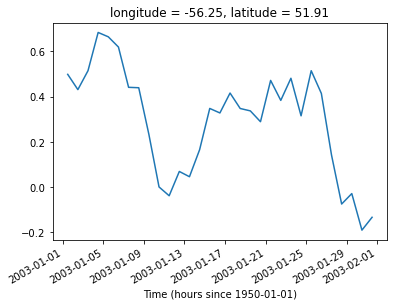

In [24]:
(transport_bar/1e6).plot()

# Now full transport (as opposed to barotropic)

In [25]:
u_interp = interpolate_transect(d.uo,lons, lats)
v_interp = interpolate_transect(d.vo,lons, lats)
mask_interp = interpolate_transect(mask.mask, lons, lats, method='nearest')
e3t_interp = interpolate_transect(coords.e3t, lons, lats)

In [26]:

transport= calculate_transport(u_interp, v_interp, dir_east_perp, dir_north_perp, barotropic=False,
                               mask_transect=mask_interp, e3t_transect=e3t_interp)

In [27]:
transport.values/1e6

array([ 0.31744869,  0.27312694,  0.32646835,  0.43402281,  0.42001369,
        0.39370072,  0.27930858,  0.27328275,  0.14803712,  0.00874438,
       -0.01395369,  0.0469953 ,  0.03260491,  0.10240368,  0.2144324 ,
        0.20420614,  0.25860433,  0.21732018,  0.21302548,  0.18100204,
        0.29398056,  0.23709746,  0.29741687,  0.19554053,  0.31921535,
        0.25864399,  0.08942379, -0.04031078, -0.01299037, -0.11353824,
       -0.08223958])

In [28]:
np.mean(transport.values/1e6)

0.1862269164322763

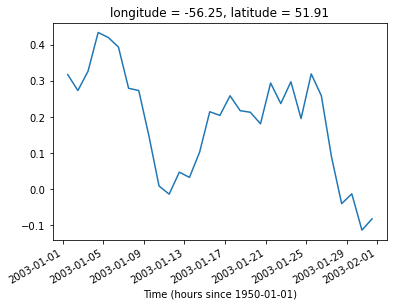

In [29]:
(transport/1e6).plot()

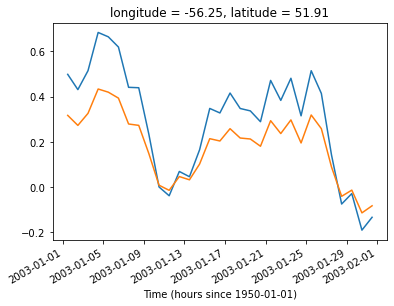

In [30]:
fig, ax = plt.subplots(1,1)
(transport_bar/1e6).plot(ax=ax,label='baratropic')
(transport/1e6).plot(ax=ax,label='full')

The difference between the barotropic and full transport is larger than I thought it would be. I wonder if we could be loosing information by interpolating to the transect before computing the depth integration. That is - the interpolation isn't handling the masked data very well and so the interpolated results aren't as deep as the should be?

Note: Smith et al uses a depth-averaged transport (ie the barotropic)

## Check on interpolation of mask, e3t, etc along the transect

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(500.0, 0.0)

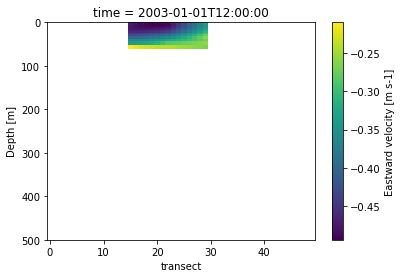

In [31]:
print(mask_interp.values)
fig,ax = plt.subplots(1,1)
u_interp.isel(time=0).plot(ax=ax)
ax.set_ylim([500,0])

(500.0, 0.0)

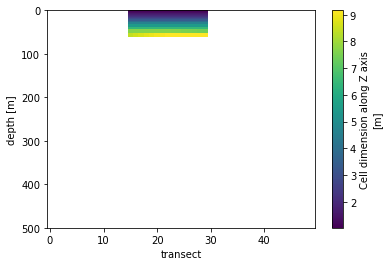

In [32]:
fig,ax = plt.subplots(1,1)
e3t_interp.plot(ax=ax)
ax.set_ylim([500,0])

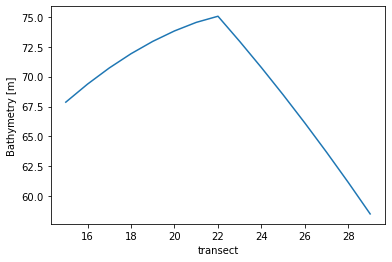

In [33]:
depth_interp = interpolate_transect(mask.deptho, lons,lats)
depth_interp.plot()

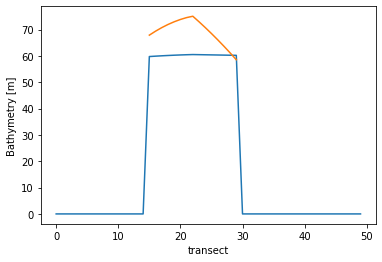

In [34]:
fig,ax=plt.subplots()
depth = np.sum(e3t_interp*mask_interp, axis=0)
depth.plot(ax=ax)
depth_interp.plot(ax=ax)

* Orange line is the deptho interpolated to the transect
* Blue line depths calculated by summing the interpolated e3t variable. So yes, there could be a difference in the volume summed in each of these method.

In [45]:
transect = vectorize_transect(lons, lats,  dir_east_perp, dir_north_perp)
area1 = 0
area2 = 0
for i in range(len(transect)):
    ref_vector = transect[i]
    area1 += depth[i]*np.abs(ref_vector)
    area2 += depth_interp[i]*np.abs(ref_vector) if ~np.isnan(depth_interp[i]) else 0

In [46]:
print(area1,area2)

<xarray.DataArray ()>
array(673761.72996662)
Coordinates:
    longitude  float64 -56.25
    latitude   float64 51.91 <xarray.DataArray 'deptho' ()>
array(773830.71064617)
Coordinates:
    longitude  float64 -56.21
    latitude   float64 51.74


In [47]:
(area2-area1)/area2

<xarray.DataArray ()>
array(0.12931637)
Coordinates:
    longitude  float64 -56.21
    latitude   float64 51.74

In [49]:
rel_diff = (transport_bar - transport)/transport_bar

In [50]:
rel_diff.values

array([ 0.36359124,  0.36673824,  0.36612025,  0.36546527,  0.36815014,
        0.36456897,  0.36732568,  0.37838563,  0.36581085, -7.28380546,
        0.63164072,  0.32377614,  0.2950422 ,  0.38174302,  0.38403068,
        0.37765194,  0.3786992 ,  0.37532768,  0.36845361,  0.37457231,
        0.37710453,  0.38215876,  0.38232118,  0.38013663,  0.38002106,
        0.37597031,  0.37245928,  0.45845792,  0.54052963,  0.40198423,
        0.38190117])

So there is a ~13% difference in the area of the cross section and closer to 40% difference between the full transport and depth=averaged transport.

I wonder if there is a better way to interpolate to that transect. 

Regardless, the depth-averaged approach is typical and I will use that.